# Setup  (borrowed from the Ch. 3 notebook)

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed as well as Scikit-Learn ≥0.20.

from sklearn.model_selection import cross_val_score

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Timing code

(borrowed from https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python)

In [2]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start
    


In [3]:
with elapsed_timer() as my_timer:
    sum = 0
    for x in range(1000000):
        sum += x
    print(my_timer())
    for x in range(1000000):
        sum += x
     
print(my_timer())

0.08128666700213216
0.16769833301077597


# MNIST

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X.iloc[0].values
X_train.shape

(60000, 784)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.transform(X_test.astype(np.float64))

# Multiclass classification

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [11]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train_scaled[:1000], y_train[:1000]) 
svm_clf.predict([some_digit])


array([7], dtype=uint8)

In [12]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train_scaled[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([7], dtype=uint8)

In [13]:
len(ovr_clf.estimators_)

10

In [14]:
with elapsed_timer() as sgd_timer:
    sgd_clf.fit(X_train_scaled, y_train)
print(f"sgd_clf.fit took {sgd_timer():.3f} secs")  # 300 seconds on my laptop
sgd_clf.predict([some_digit])

sgd_clf.fit took 247.312 secs


array([3], dtype=uint8)

In [15]:
sgd_clf.decision_function([some_digit])

array([[ -52074.00622961,  -90932.76755577,  -20253.71519718,
          13700.40693397, -153621.49226805,   -4632.87432725,
        -107360.91391427,  -90145.62086593,    -980.42911341,
         -44100.09135652]])

In [17]:
# This involves training 3 models - it's going to take a while
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

In [18]:
sgd_clf.score(X_test_scaled, y_test)

0.8933

In [19]:
from sklearn.metrics import confusion_matrix
y_test_pred = sgd_clf.predict(X_test_scaled)
conf_mx_test = confusion_matrix(y_test, y_test_pred)
conf_mx_test

array([[ 937,    0,    0,    0,    0,    3,    4,    1,   35,    0],
       [   0, 1083,    5,    1,    0,    3,    4,    0,   39,    0],
       [   4,    3,  890,   14,    7,    2,   13,    6,   89,    4],
       [   4,    0,   13,  874,    0,   20,    2,    7,   82,    8],
       [   1,    0,    6,    0,  877,    1,    6,    4,   66,   21],
       [   5,    2,    1,   31,    8,  716,   17,    7,   98,    7],
       [  10,    2,   10,    0,    8,   13,  881,    1,   33,    0],
       [   2,    2,   16,    5,    5,    1,    0,  924,   49,   24],
       [   6,    4,    4,   15,    3,   24,    8,    1,  905,    4],
       [   5,    5,    0,    6,   24,    4,    0,   21,   98,  846]])

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_test, y_test_pred, average="macro"), \
    recall_score(y_test, y_test_pred, average="macro"), \
    f1_score(y_test, y_test_pred, average="macro")
from sklearn.metrics import accuracy_score



# Function to run experiments with different training set sizes
def run_experiments(X_train_scaled, y_train, X_test_scaled, y_test,
                    max_samples=4000, initial_samples=250):
    # Define training sizes (quadrupling each time for just 3 experiments)
    train_sizes = []
    size = initial_samples
    while size <= max_samples:
        train_sizes.append(size)
        size *= 4
    
    results = {
        "train_sizes": train_sizes,
        "svc_times": [],
        "ovr_times": [],
        "svc_scores": [],
        "ovr_scores": []
    }
    
    for train_size in train_sizes:
        print(f"\nRunning experiment with {train_size} samples...")
        
        # Subset of training data
        X_subset = X_train_scaled[:train_size]
        y_subset = y_train[:train_size]
        
        # Train SVC and measure time
        print(f"Training SVC with {train_size} samples...")
        svc_clf = SVC(gamma="auto", random_state=42)
        with elapsed_timer() as svc_timer:
            svc_clf.fit(X_subset, y_subset)
        svc_time = svc_timer()
        results["svc_times"].append(svc_time)
        
        # Measure SVC accuracy
        y_pred = svc_clf.predict(X_test_scaled)
        svc_score = accuracy_score(y_test, y_pred)
        results["svc_scores"].append(svc_score)
        
        print(f"SVC trained in {svc_time:.2f} seconds, Test accuracy: {svc_score:.4f}")
        
        # Train OneVsRest SVC and measure time
        print(f"Training OneVsRest with {train_size} samples...")
        ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
        with elapsed_timer() as ovr_timer:
            ovr_clf.fit(X_subset, y_subset)
        ovr_time = ovr_timer()
        results["ovr_times"].append(ovr_time)
        
        # Measure OneVsRest accuracy
        y_pred = ovr_clf.predict(X_test_scaled)
        ovr_score = accuracy_score(y_test, y_pred)
        results["ovr_scores"].append(ovr_score)
        
        print(f"OneVsRest trained in {ovr_time:.2f} seconds, Test accuracy: {ovr_score:.4f}")
        
        # Save intermediate results to a file in case the script crashes
        np.save("mnist_experiment_results.npy", results)
    
    return results

In [23]:
# Run experiments
print("Starting experiments...")
results = run_experiments(X_train_scaled, y_train, X_test_scaled, y_test)

Starting experiments...

Running experiment with 250 samples...
Training SVC with 250 samples...
SVC trained in 0.07 seconds, Test accuracy: 0.7222
Training OneVsRest with 250 samples...
OneVsRest trained in 0.10 seconds, Test accuracy: 0.7377

Running experiment with 1000 samples...
Training SVC with 1000 samples...
SVC trained in 0.34 seconds, Test accuracy: 0.8717
Training OneVsRest with 1000 samples...
OneVsRest trained in 0.96 seconds, Test accuracy: 0.8655

Running experiment with 4000 samples...
Training SVC with 4000 samples...
SVC trained in 2.98 seconds, Test accuracy: 0.9187
Training OneVsRest with 4000 samples...
OneVsRest trained in 10.82 seconds, Test accuracy: 0.9169


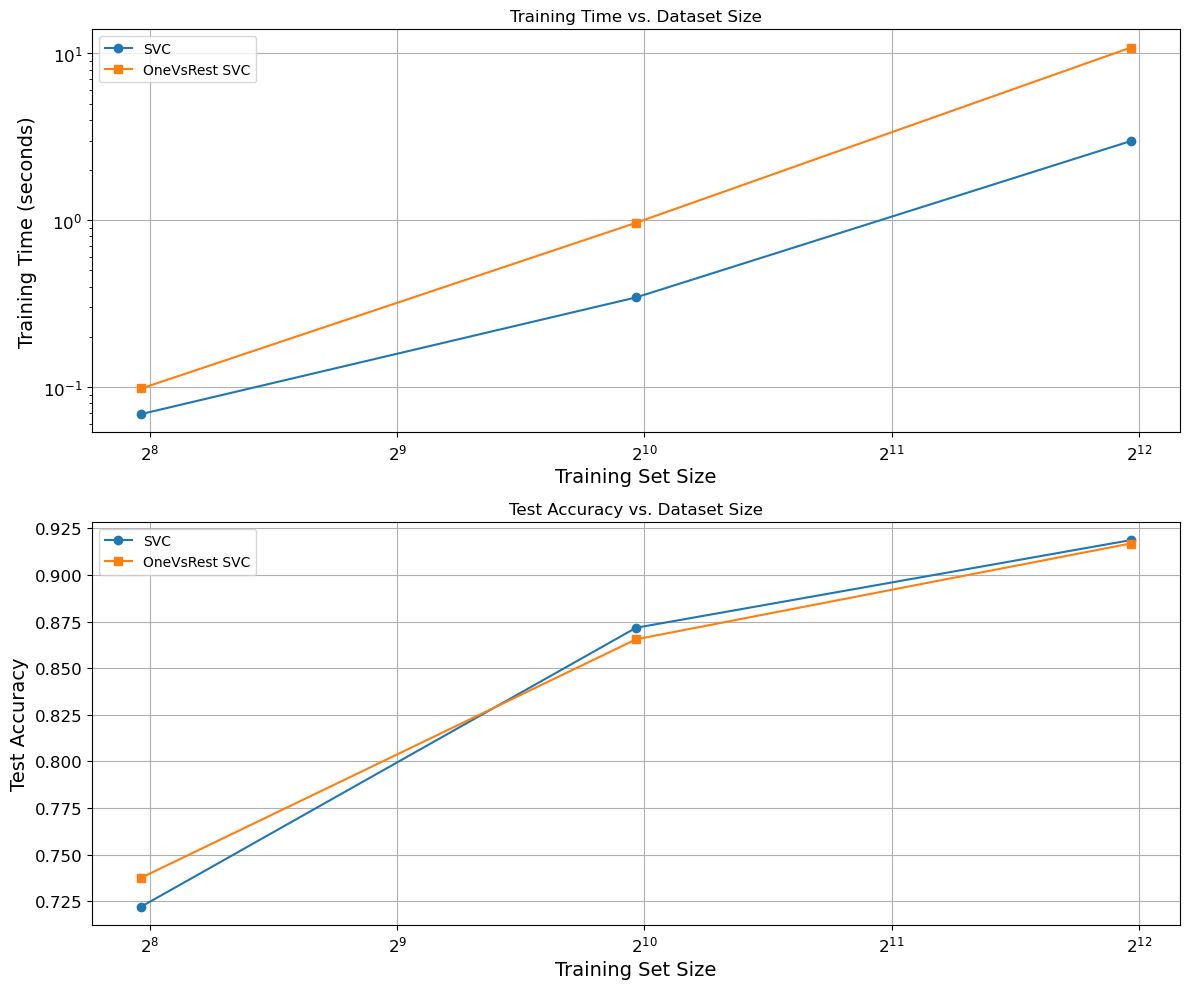


Final Results:
--------------------------------------------------------------------------------
Train Size | SVC Time (s) | OVR Time (s) | SVC Accuracy | OVR Accuracy
--------------------------------------------------------------------------------
250        | 0.07         | 0.10         | 0.7222       | 0.7377      
1000       | 0.34         | 0.96         | 0.8717       | 0.8655      
4000       | 2.98         | 10.82        | 0.9187       | 0.9169      


In [24]:
# Plot results
plt.figure(figsize=(12, 10))

# Plot training times
plt.subplot(2, 1, 1)
plt.plot(results["train_sizes"], results["svc_times"], 'o-', label='SVC')
plt.plot(results["train_sizes"], results["ovr_times"], 's-', label='OneVsRest SVC')
plt.xlabel('Training Set Size')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time vs. Dataset Size')
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)  # Log scale for x-axis
plt.yscale('log')  # Log scale for better visualization

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(results["train_sizes"], results["svc_scores"], 'o-', label='SVC')
plt.plot(results["train_sizes"], results["ovr_scores"], 's-', label='OneVsRest SVC')
plt.xlabel('Training Set Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Dataset Size')
plt.legend()
plt.grid(True)
plt.xscale('log', base=2)  # Log scale for x-axis

plt.tight_layout()
plt.savefig('mnist_experiment_results.png')
plt.show()

# Print final results in a table format
print("\nFinal Results:")
print("-" * 80)
print(f"{'Train Size':<10} | {'SVC Time (s)':<12} | {'OVR Time (s)':<12} | {'SVC Accuracy':<12} | {'OVR Accuracy':<12}")
print("-" * 80)
for i, size in enumerate(results["train_sizes"]):
    print(f"{size:<10} | {results['svc_times'][i]:<12.2f} | {results['ovr_times'][i]:<12.2f} | {results['svc_scores'][i]:<12.4f} | {results['ovr_scores'][i]:<12.4f}")

In [37]:


def trim_edges(X, trim_pixels):
    """
    Trim a specified number of pixels from all edges of MNIST images.
    
    Parameters:
    - X: array of flattened images (n_samples, 784) - can be DataFrame or ndarray
    - trim_pixels: number of pixels to trim from each edge
    
    Returns:
    - Flattened trimmed images as numpy array
    """
    # Convert to numpy array if it's a DataFrame
    if hasattr(X, 'values'):
        X = X.values
    
    n_samples = X.shape[0]
    
    # Original dimensions
    original_dim = 28
    
    # New dimensions after trimming
    new_dim = original_dim - 2 * trim_pixels
    
    # Resulting flattened dimension
    result_dim = new_dim * new_dim
    
    # Initialize the result array
    X_trimmed = np.zeros((n_samples, result_dim))
    
    for i in range(n_samples):
        # Reshape the image from 1D to 2D
        img = X[i].reshape(original_dim, original_dim)
        
        # Trim the edges
        trimmed_img = img[trim_pixels:original_dim-trim_pixels, 
                         trim_pixels:original_dim-trim_pixels]
        
        # Flatten the trimmed image and store it
        X_trimmed[i] = trimmed_img.flatten()
    
    return X_trimmed


trimmed_X_train = trim_edges(X_train, trim_pixels=4)
trimmed_X_test = trim_edges(X_test, trim_pixels=4)


Testing with trim_size = 0
Number of features after trimming: 784
Training time: 41.22 seconds
Test accuracy: 0.8740

Testing with trim_size = 2
Number of features after trimming: 576
Training time: 33.20 seconds
Test accuracy: 0.8827

Testing with trim_size = 4
Number of features after trimming: 400
Training time: 21.14 seconds
Test accuracy: 0.8782

Testing with trim_size = 6
Number of features after trimming: 256
Training time: 17.83 seconds
Test accuracy: 0.8347

Testing with trim_size = 8
Number of features after trimming: 144
Training time: 13.16 seconds
Test accuracy: 0.7199


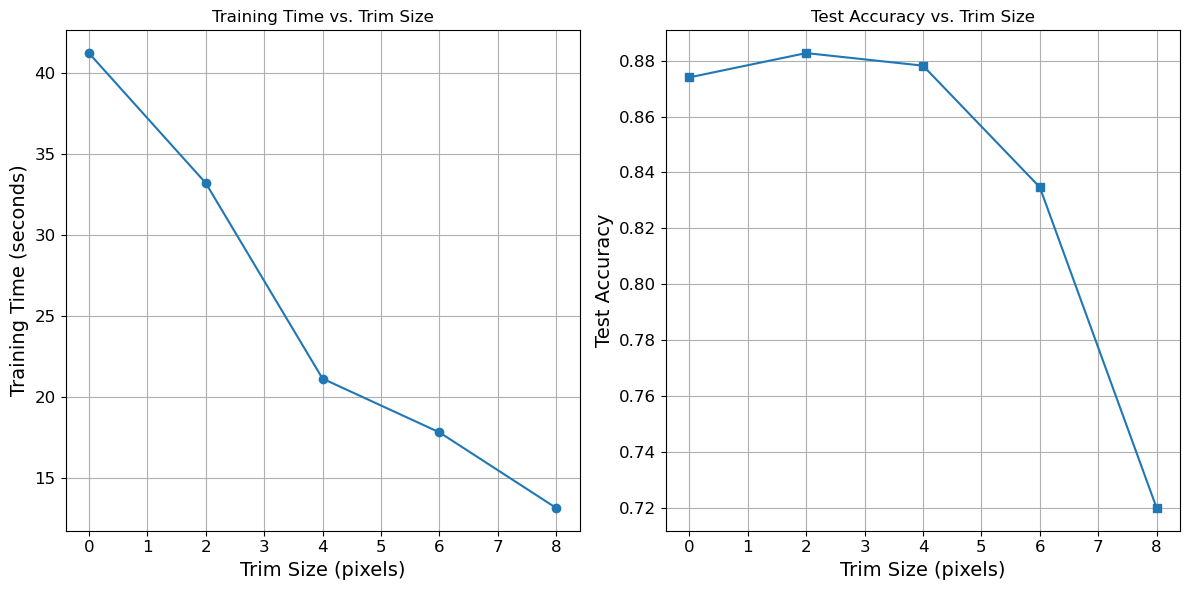

In [44]:


# Function to experiment with different trim sizes
def experiment_with_trim_sizes(X_train, y_train, X_test, y_test, trim_sizes=[0, 2, 4, 6, 8]):
    """
    Experiment with different trim sizes and evaluate model performance.
    
    Parameters:
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - trim_sizes: List of different trim sizes to try
    
    Returns:
    - Dictionary with results
    """
    results = {
        "trim_sizes": trim_sizes,
        "train_times": [],
        "accuracies": [],
        "n_features": []
    }
    
    for trim_size in trim_sizes:
        print(f"\nTesting with trim_size = {trim_size}")
        
        # Skip if trim is too large
        if trim_size * 2 >= 28:
            print(f"Trim size {trim_size} is too large, skipping")
            continue
        
        # Apply trimming
        X_train_trimmed = trim_edges(X_train, trim_size)
        X_test_trimmed = trim_edges(X_test, trim_size)
        
        # Record number of features
        n_features = X_train_trimmed.shape[1]
        results["n_features"].append(n_features)
        print(f"Number of features after trimming: {n_features}")
        
        # Train model
        clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)
        
        with elapsed_timer() as train_timer:
            clf.fit(X_train_trimmed, y_train)
        train_time = train_timer()
        results["train_times"].append(train_time)
        
        # Evaluate model
        accuracy = clf.score(X_test_trimmed, y_test)
        results["accuracies"].append(accuracy)
        
        print(f"Training time: {train_time:.2f} seconds")
        print(f"Test accuracy: {accuracy:.4f}")
    
    return results



def plot_trimming_results(results):
    """
    Plot the results of the trimming experiments.
    
    Parameters:
    - results: Dictionary containing the results from the trimming experiments
    """
    plt.figure(figsize=(12, 6))
    
    # Plot training times
    plt.subplot(1, 2, 1)
    plt.plot(results["trim_sizes"], results["train_times"], 'o-')
    plt.xlabel('Trim Size (pixels)')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Trim Size')
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(results["trim_sizes"], results["accuracies"], 's-')
    plt.xlabel('Trim Size (pixels)')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Trim Size')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the trimming experiments
trim_results = experiment_with_trim_sizes(X_train, y_train, X_test, y_test)
plot_trimming_results(trim_results)


# Here we can see at four pixels we have found a good balance between trim sizes and compute times

In [ ]:
# Function to create a mask based on pixel importance
def create_importance_mask(importance, threshold):
    """
    Create a mask for selecting features based on importance values.
    
    Parameters:
    - importance: Array of importance values for each pixel (784,)
    - threshold: Keep only pixels with importance > threshold
    
    Returns:
    - Boolean mask of shape (784,)
    """
    return importance > threshold

# Function to apply mask to images
def apply_mask(X, mask):
    """
    Apply a mask to select only important pixels.
    
    Parameters:
    - X: array of flattened images (n_samples, 784)
    - mask: Boolean mask of shape (784,)
    
    Returns:
    - Masked features, with only important pixels
    """

    X = X.values
    return X[:, mask]

# Function to experiment with different importance thresholds
def experiment_with_importance(X_train, y_train, X_test, y_test, importance, thresholds):
    """
    Experiment with different importance thresholds and evaluate model performance.
    
    Parameters:
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - importance: Array of importance values for each pixel (784,)
    - thresholds: List of different thresholds to try
    
    Returns:
    - Dictionary with results
    """
    results = {
        "thresholds": thresholds,
        "train_times": [],
        "accuracies": [],
        "n_features": []
    }
    
    for threshold in thresholds:
        print(f"\nTesting with importance threshold = {threshold}")
        
        # Create mask
        mask = create_importance_mask(importance, threshold)
        
        # Apply mask
        X_train_masked = apply_mask(X_train, mask)
        X_test_masked = apply_mask(X_test, mask)
        
        # Record number of features
        n_features = X_train_masked.shape[1]
        results["n_features"].append(n_features)
        print(f"Number of features after masking: {n_features}")
        
        # Train model
        clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)
        
        with elapsed_timer() as train_timer:
            clf.fit(X_train_masked, y_train)
        train_time = train_timer()
        results["train_times"].append(train_time)
        
        # Evaluate model
        accuracy = clf.score(X_test_masked, y_test)
        results["accuracies"].append(accuracy)
        
        print(f"Training time: {train_time:.2f} seconds")
        print(f"Test accuracy: {accuracy:.4f}")
    
    return results



In [47]:

# Function to visualize results
def plot_importance_results(results):
    """
    Plot the results of the importance experiments.
    
    Parameters:
    - results: Dictionary containing the results from the importance experiments
    """
    plt.figure(figsize=(12, 6))
    
    # Plot training times
    plt.subplot(1, 2, 1)
    plt.plot(results["thresholds"], results["train_times"], 'o-')
    plt.xlabel('Importance Threshold')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Importance Threshold')
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(results["thresholds"], results["accuracies"], 's-')
    plt.xlabel('Importance Threshold')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Importance Threshold')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()



In [58]:

# Example usage of the plot_results function
importance = np.random.rand(784)  # Random importance values for demonstration
thresholds = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5]

importance_results = experiment_with_importance(X_train, y_train, X_test, y_test, importance, thresholds)



Testing with importance threshold = 0.1
Number of features after masking: 699
Training time: 29.67 seconds
Test accuracy: 0.8889

Testing with importance threshold = 0.2
Number of features after masking: 619
Training time: 33.66 seconds
Test accuracy: 0.8775

Testing with importance threshold = 0.25
Number of features after masking: 580
Training time: 25.37 seconds
Test accuracy: 0.8940

Testing with importance threshold = 0.3
Number of features after masking: 543
Training time: 27.42 seconds
Test accuracy: 0.8573

Testing with importance threshold = 0.4
Number of features after masking: 467
Training time: 21.64 seconds
Test accuracy: 0.8870

Testing with importance threshold = 0.5
Number of features after masking: 381
Training time: 19.03 seconds
Test accuracy: 0.8593


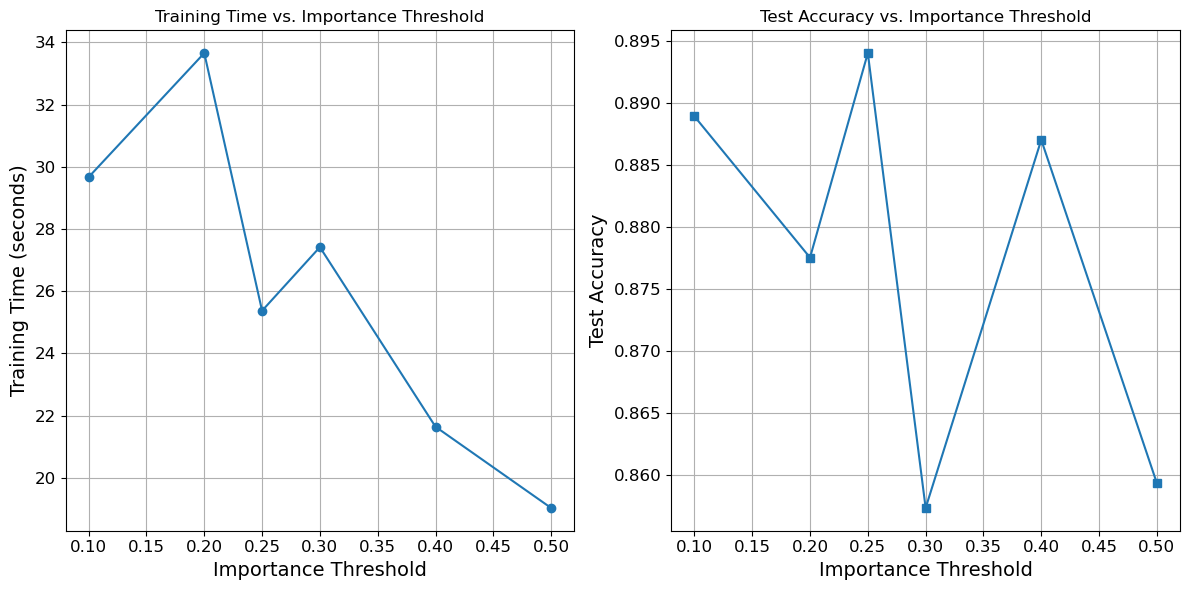

In [59]:

plot_importance_results(importance_results)

In [60]:
from sklearn.decomposition import PCA

# Function to perform PCA and evaluate model performance
def experiment_with_pca(X_train, y_train, X_test, y_test, components_list):
    """
    Experiment with PCA using different numbers of components.
    
    Parameters:
    - X_train, y_train: Training data
    - X_test, y_test: Test data
    - components_list: List of numbers of components to try
    
    Returns:
    - Dictionary with results
    """
    results = {
        "n_components": components_list,
        "train_times": [],
        "pca_times": [],
        "fit_times": [],
        "accuracies": [],
        "explained_variance": []
    }
    
    for n_components in components_list:
        print(f"\nTesting PCA with {n_components} components")
        
        # Apply PCA
        with elapsed_timer() as pca_timer:
            pca = PCA(n_components=n_components, random_state=42)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)
        pca_time = pca_timer()
        results["pca_times"].append(pca_time)
        
        # Record explained variance
        explained_variance = np.sum(pca.explained_variance_ratio_) * 100
        results["explained_variance"].append(explained_variance)
        print(f"PCA time: {pca_time:.2f} seconds")
        print(f"Explained variance: {explained_variance:.2f}%")
        
        # Train model
        clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1)
        
        with elapsed_timer() as fit_timer:
            clf.fit(X_train_pca, y_train)
        fit_time = fit_timer()
        results["fit_times"].append(fit_time)
        
        # Total training time (PCA + model fitting)
        results["train_times"].append(pca_time + fit_time)
        
        # Evaluate model
        accuracy = clf.score(X_test_pca, y_test)
        results["accuracies"].append(accuracy)
        
        print(f"Model fitting time: {fit_time:.2f} seconds")
        print(f"Total training time: {pca_time + fit_time:.2f} seconds")
        print(f"Test accuracy: {accuracy:.4f}")
    
    return results

# Function to find number of components needed for a specified variance
def find_components_for_variance(X, variance_threshold=0.8):
    """
    Find the number of components needed to explain a specific amount of variance.
    
    Parameters:
    - X: Input data
    - variance_threshold: Target explained variance (default: 0.8 for 80%)
    
    Returns:
    - Number of components needed
    - Actual explained variance
    - PCA object
    """
    # Use a high number of components initially to get variance ratios
    pca = PCA(random_state=42)
    pca.fit(X)
    
    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Find number of components needed
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    actual_variance = cumulative_variance[n_components - 1]
    
    return n_components, actual_variance, pca

In [67]:
data_len = len(X_train_scaled)

input_sizes = [10, 30, 60, 90, 120, 180, 240, 280, 320]  # Different sizes for PCA experiments


# Run PCA experiments with the same dimensions as edge trimming
pca_results = experiment_with_pca(X_train, y_train, X_test, y_test, input_sizes)

# Part 2: PCA with 80% variance preservation
print("\nPart 2: PCA with 80% Variance Preservation")
print("-" * 50)

# Find the number of components needed for 80% variance
n_components_80, variance_80, pca_full = find_components_for_variance(X_train, 0.8)
print(f"Number of components needed for 80% variance: {n_components_80}")
print(f"Actual explained variance: {variance_80 * 100:.2f}%")

# Run experiment with this number of components
pca_80_results = experiment_with_pca(X_train, y_train, X_test, y_test, [n_components_80])



Testing PCA with 10 components
PCA time: 1.00 seconds
Explained variance: 48.81%
Model fitting time: 0.79 seconds
Total training time: 1.79 seconds
Test accuracy: 0.7647

Testing PCA with 30 components
PCA time: 1.33 seconds
Explained variance: 73.05%
Model fitting time: 1.52 seconds
Total training time: 2.85 seconds
Test accuracy: 0.8630

Testing PCA with 60 components
PCA time: 0.99 seconds
Explained variance: 85.26%
Model fitting time: 2.48 seconds
Total training time: 3.47 seconds
Test accuracy: 0.8873

Testing PCA with 90 components
PCA time: 1.04 seconds
Explained variance: 90.38%
Model fitting time: 4.87 seconds
Total training time: 5.91 seconds
Test accuracy: 0.8880

Testing PCA with 120 components
PCA time: 0.95 seconds
Explained variance: 93.12%
Model fitting time: 5.08 seconds
Total training time: 6.03 seconds
Test accuracy: 0.8799

Testing PCA with 180 components
PCA time: 1.10 seconds
Explained variance: 96.03%
Model fitting time: 9.03 seconds
Total training time: 10.13 s

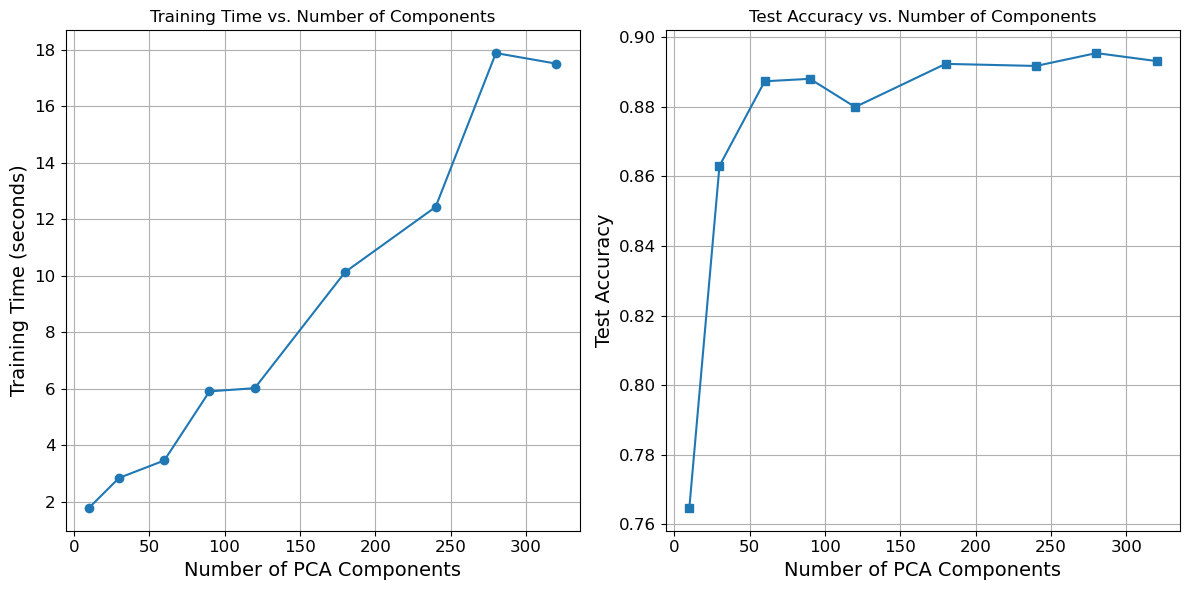

In [68]:
def plot_pca_results(results):
    """
    Plot the results of the PCA experiments.
    
    Parameters:
    - results: Dictionary containing the results from the PCA experiments
    """
    plt.figure(figsize=(12, 6))
    
    # Plot training times
    plt.subplot(1, 2, 1)
    plt.plot(results["n_components"], results["train_times"], 'o-')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time vs. Number of Components')
    plt.grid(True)
    
    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(results["n_components"], results["accuracies"], 's-')
    plt.xlabel('Number of PCA Components')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs. Number of Components')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot PCA results
plot_pca_results(pca_results)